<a href="https://colab.research.google.com/github/alkifani/Beanalyze/blob/main/beanalyze_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Ultralytics
%pip install "ultralytics<=8.3.40" supervision roboflow

# Mengecek versi dan dependensi Ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.8/112.6 GB disk)


In [2]:
# Menentukan direktori kerja saat ini
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
# Membuat folder datasets untuk menyimpan dataset
!mkdir {HOME}/datasets
%cd {HOME}/datasets

# Mengimpor Roboflow dan mengambil API key dari Colab
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# Mengakses dataset versi tertentu dari workspace dan project Roboflow
project = rf.workspace("beanalyze").project("beanalyze-object-detection")
version = project.version(12)
dataset = version.download("yolov11")  # Format YOLOv11

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Beanalyze-Object-Detection-12 in yolov11:: 100%|██████████| 16012/16012 [00:01<00:00, 11248.03it/s]


In [4]:
# Konversi gambar ke grayscale lalu kembali ke RGB untuk augmentasi tambahan
from PIL import Image
import glob

image_paths = glob.glob(f"{dataset.location}/train/images/*.jpg")
for path in image_paths:
    img = Image.open(path).convert("L").convert("RGB")
    base = path.split("/")[-1].replace(".jpg", "_gray.jpg")
    img.save(f"{dataset.location}/train/images/{base}")

    # Salin label yang sesuai dengan file grayscale
    label_path = path.replace("/images/", "/labels/").replace(".jpg", ".txt")
    label_base = label_path.split("/")[-1].replace(".txt", "_gray.txt")
    os.system(f"cp {label_path} {dataset.location}/train/labels/{label_base}")


In [5]:
# Kembali ke direktori utama untuk menjalankan pelatihan
%cd {HOME}

# Melatih model YOLOv11 dengan berbagai teknik augmentasi
!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=15 imgsz=640 \
hsv_h=0.05 hsv_s=0.6 hsv_v=0.6 \
degrees=10.0 translate=0.2 scale=0.5 \
shear=5.0 perspective=0.001 \
flipud=0.1 fliplr=0.5 \
mosaic=1.0 mixup=0.2 copy_paste=0.2

/content
100% 18.4M/18.4M [00:00<00:00, 64.4MB/s]
New https://pypi.org/project/ultralytics/8.3.152 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Beanalyze-Object-Detection-12/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic

In [6]:
# Melihat isi folder output pelatihan
!ls {HOME}/runs/detect/train/

args.yaml					     train_batch1.jpg
confusion_matrix_normalized.png			     train_batch2.jpg
confusion_matrix.png				     train_batch4000.jpg
events.out.tfevents.1749478414.b9357c5812be.13833.0  train_batch4001.jpg
F1_curve.png					     train_batch4002.jpg
labels_correlogram.jpg				     val_batch0_labels.jpg
labels.jpg					     val_batch0_pred.jpg
P_curve.png					     val_batch1_labels.jpg
PR_curve.png					     val_batch1_pred.jpg
R_curve.png					     val_batch2_labels.jpg
results.csv					     val_batch2_pred.jpg
results.png					     weights
train_batch0.jpg


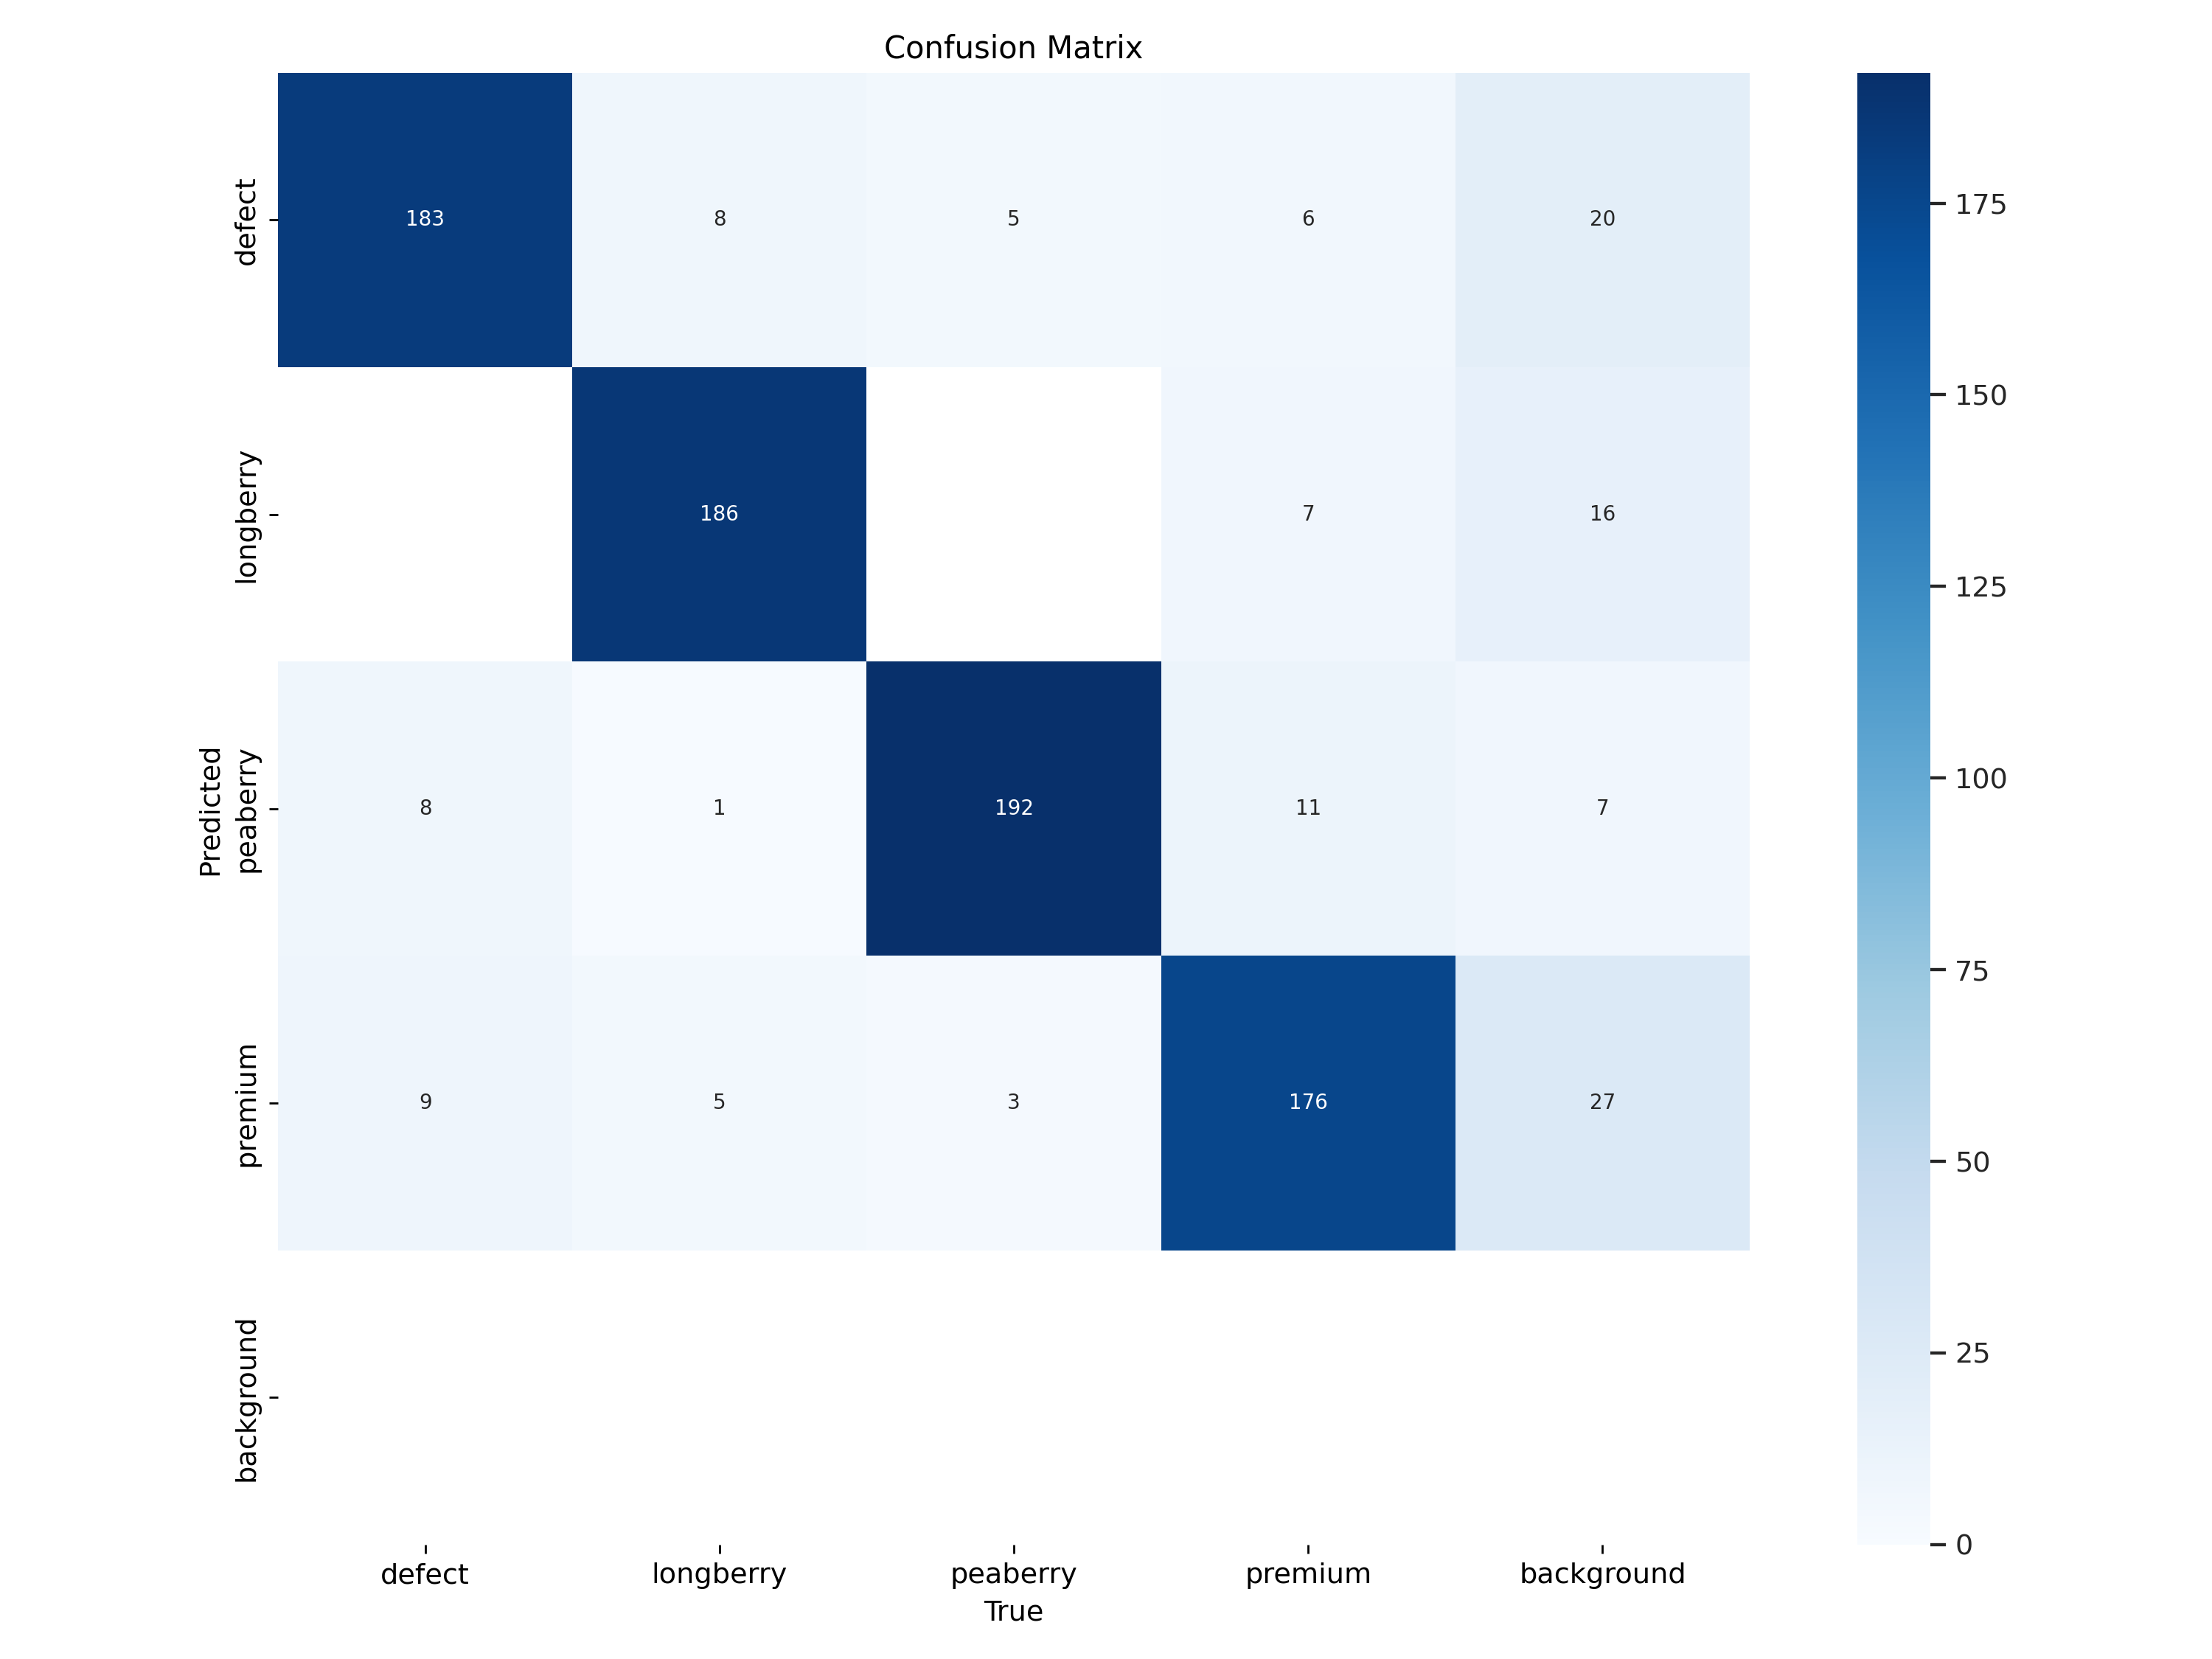

In [7]:
# Menampilkan confusion matrix dari hasil pelatihan
from IPython.display import Image as IPyImage
IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

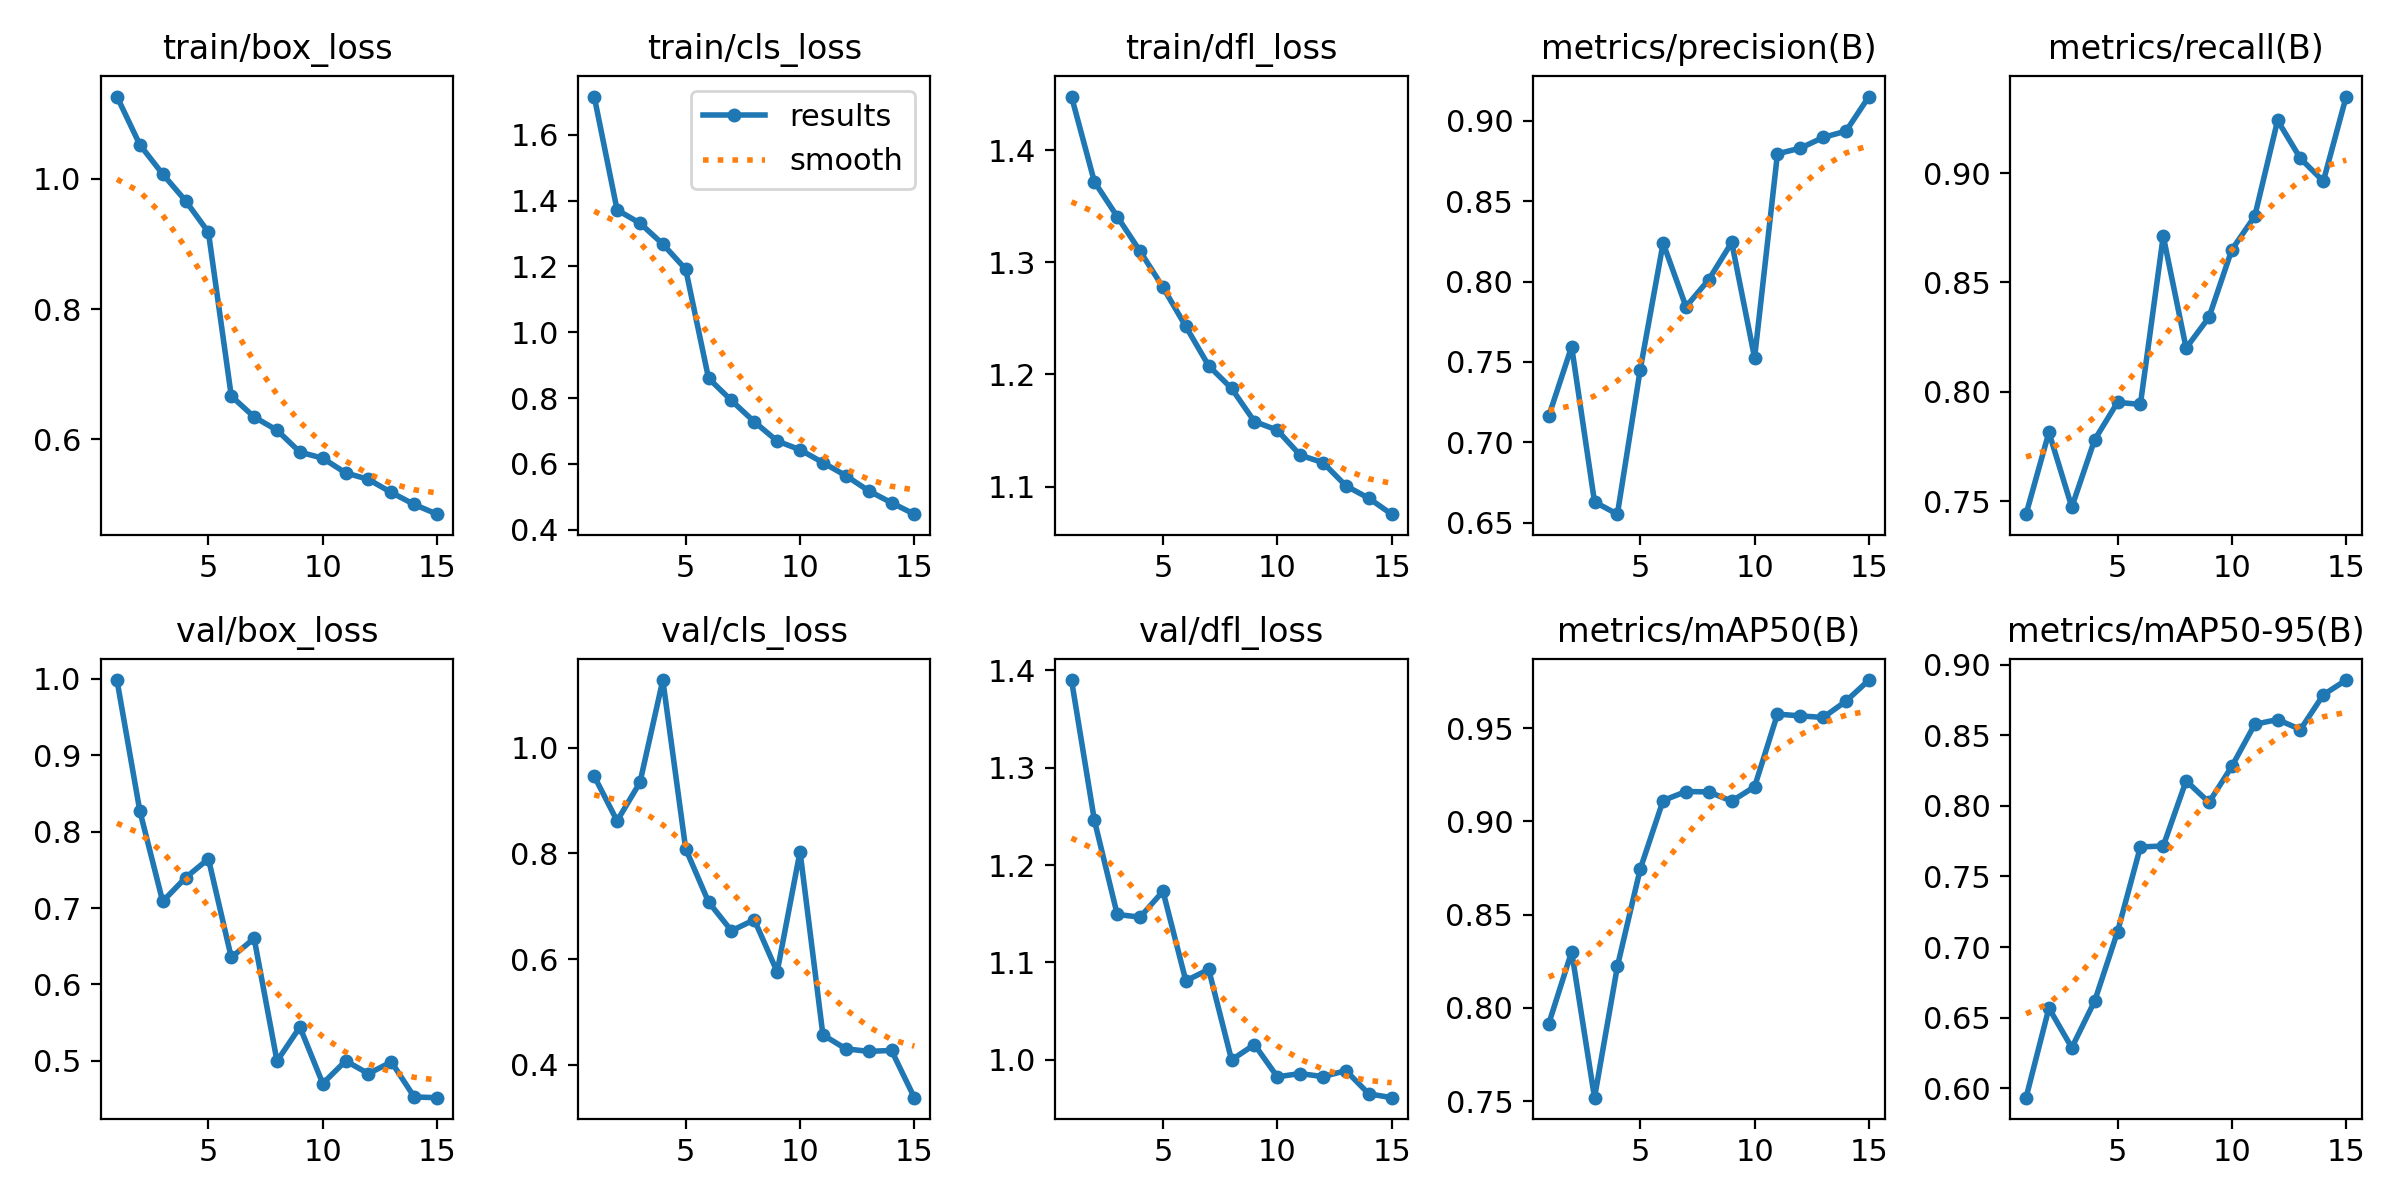

In [8]:
# Menampilkan hasil metrik pelatihan per epoch
IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

In [9]:
# Validasi model hasil pelatihan
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Beanalyze-Object-Detection-12/valid/labels.cache... 800 images, 0 backgrounds, 0 corrupt: 100% 800/800 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 50/50 [00:11<00:00,  4.45it/s]
                   all        800        800      0.916      0.935      0.976      0.889
                defect        200        200      0.899      0.935      0.969      0.916
             longberry        200        200      0.936      0.954      0.986       0.84
              peaberry        200        200      0.904      0.955      0.984      0.899
               premium        200        200      0.923      0.894      0.963      0.903
Speed: 0.8ms preprocess, 8.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/

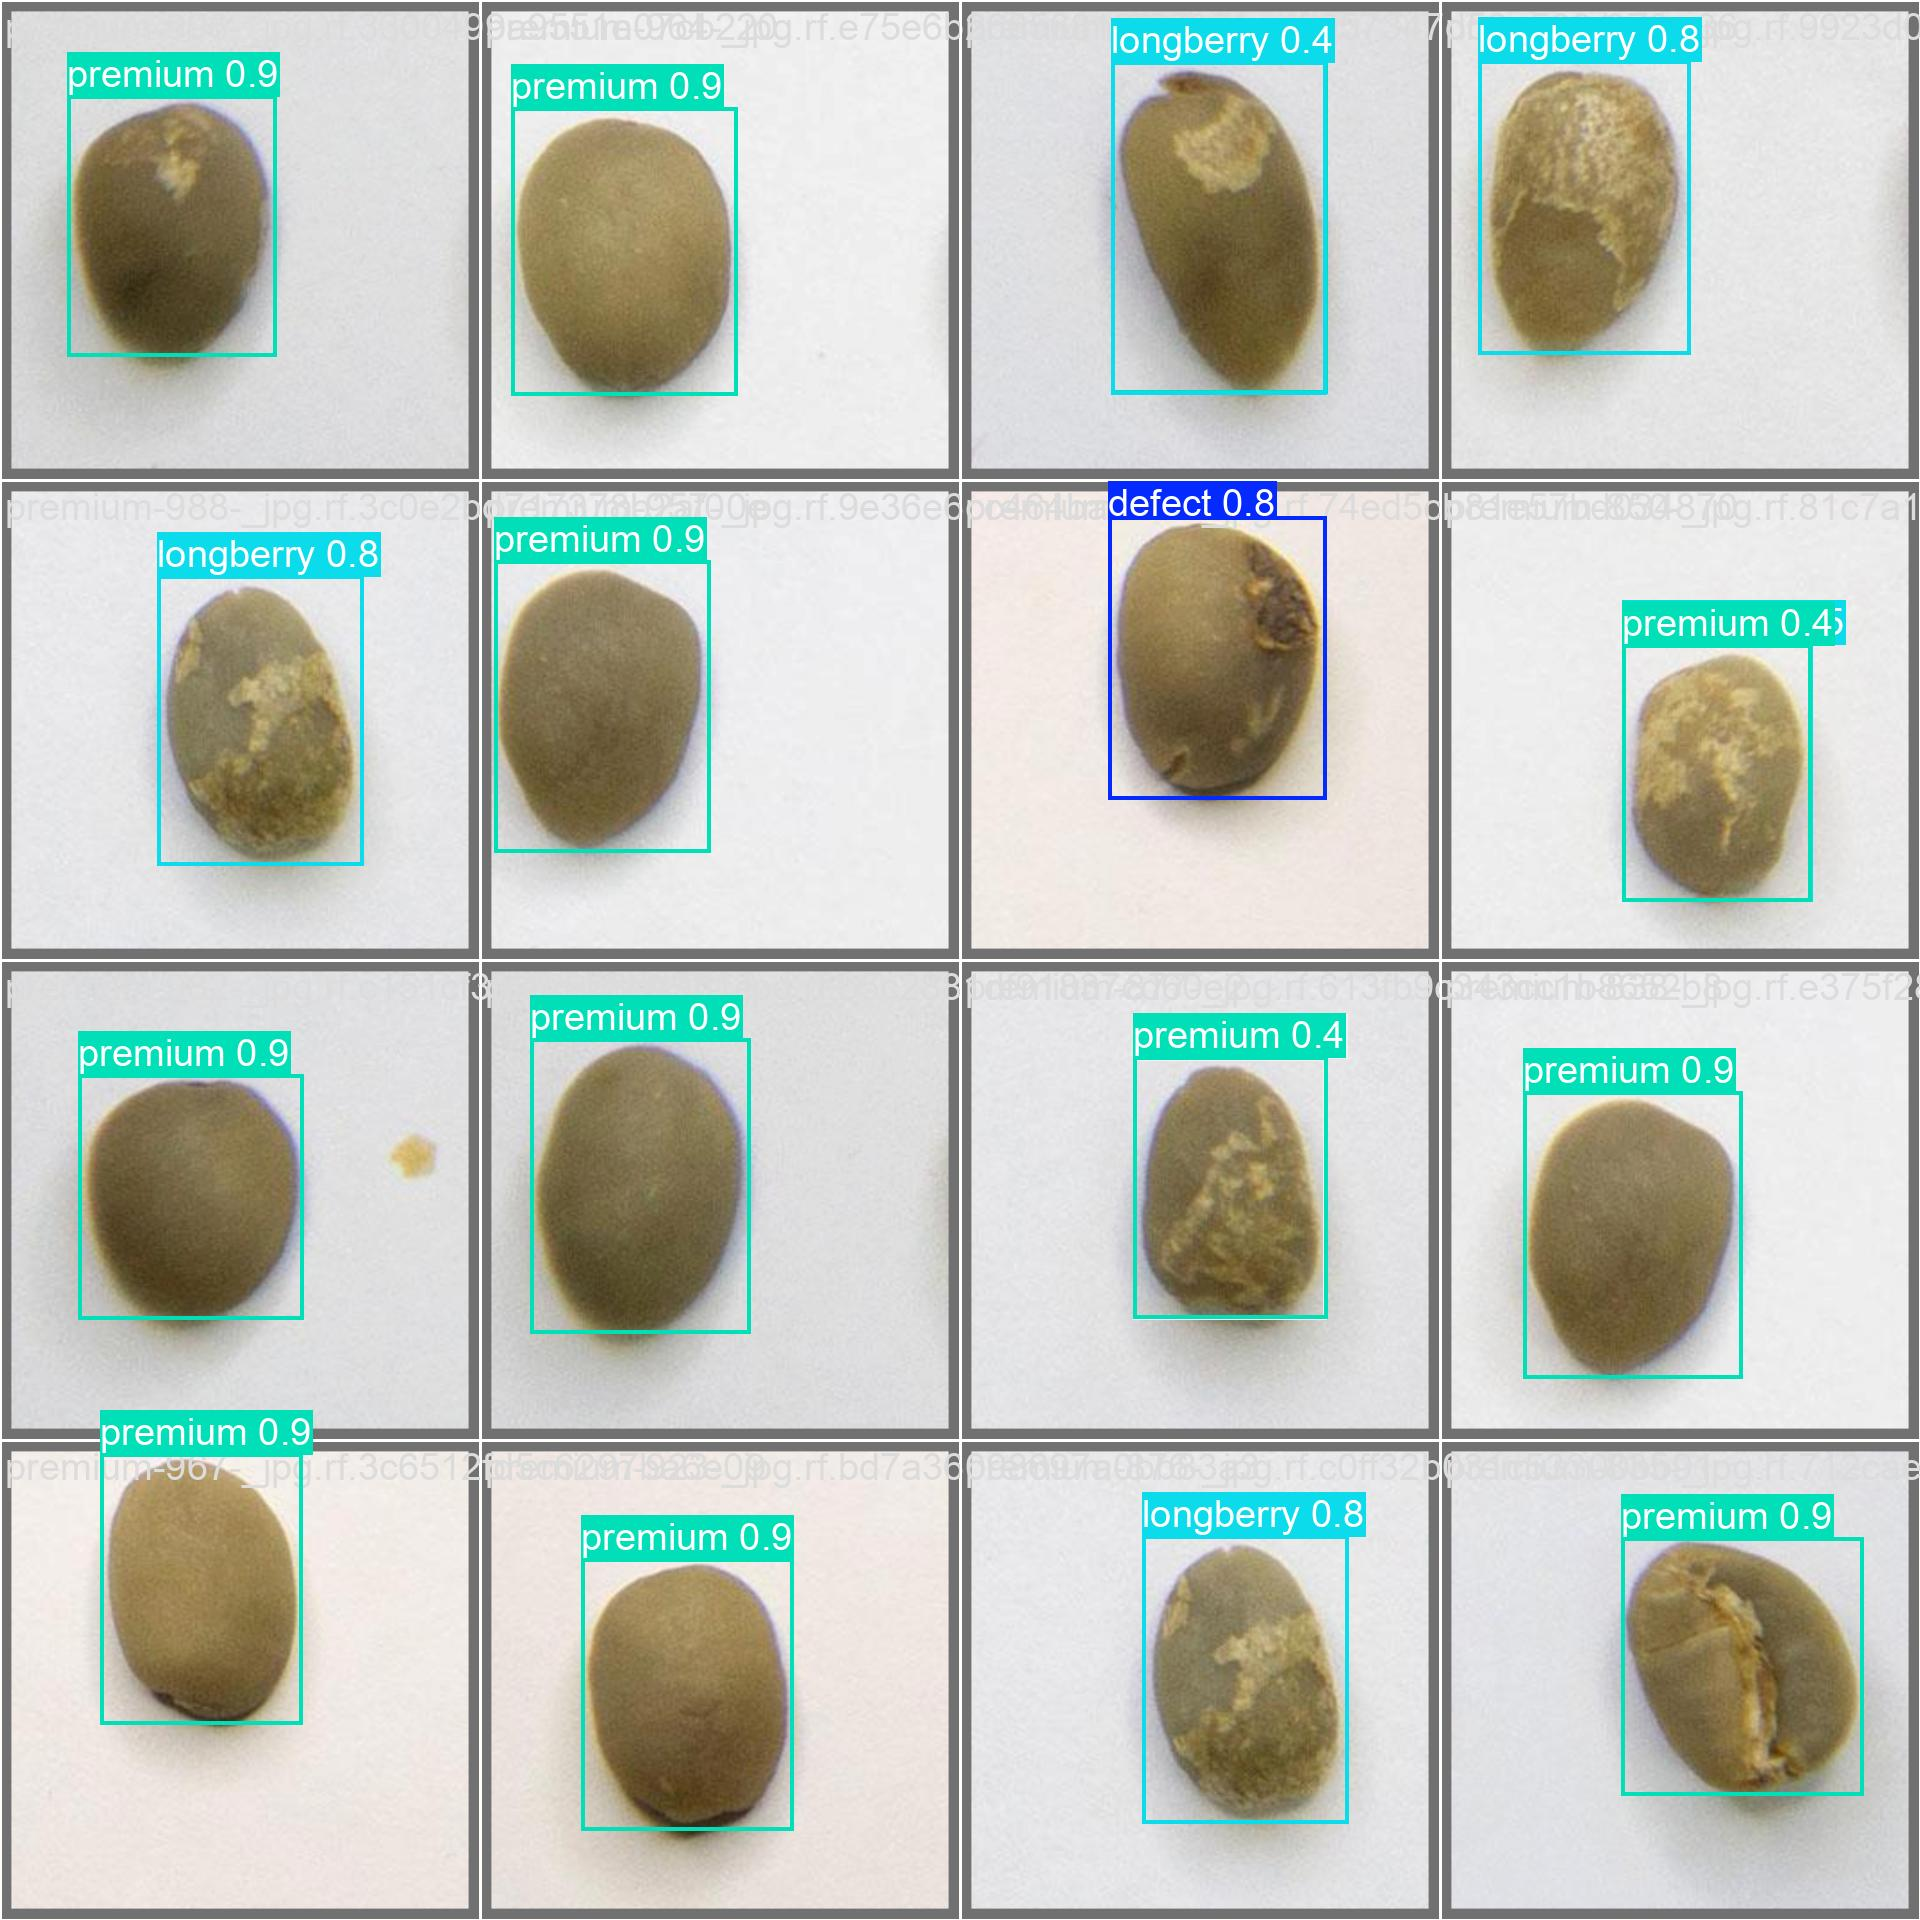

In [10]:
# Menampilkan contoh hasil prediksi validasi
IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [11]:
# Melakukan prediksi pada data test
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

image 1/800 /content/datasets/Beanalyze-Object-Detection-12/test/images/defect-1-_jpg.rf.6a08a6b8b975fd05bf0523d90962eb6a.jpg: 640x640 1 defect, 15.3ms
image 2/800 /content/datasets/Beanalyze-Object-Detection-12/test/images/defect-100-_jpg.rf.93c0dce7b2f1084110a04a27c38ba4c3.jpg: 640x640 1 premium, 15.3ms
image 3/800 /content/datasets/Beanalyze-Object-Detection-12/test/images/defect-1003-_jpg.rf.61957534f61fbb20050a1d2ece154b25.jpg: 640x640 1 defect, 15.3ms
image 4/800 /content/datasets/Beanalyze-Object-Detection-12/test/images/defect-1005-_jpg.rf.4fecac25f8d9f4e60baa8d6b45386753.jpg: 640x640 1 defect, 15.2ms
image 5/800 /content/datasets/Beanalyze-Object-Detection-12/test/images/defect-1007-_jpg.rf.2a81b29ce2ed2807e7c213c6ef8fb0fd.jpg: 640x640 1 defect, 15.2ms
image 6/800 /content/datasets/Beanalyze-Object-Detection-12/t

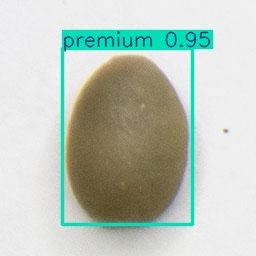

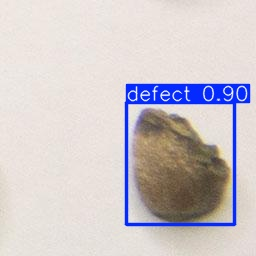

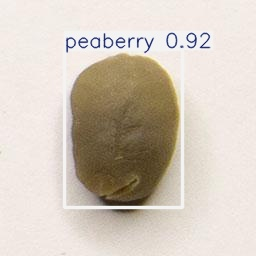

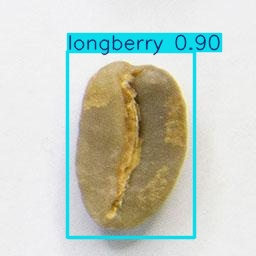

In [12]:
# Menampilkan hasil prediksi
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:4]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [23]:
# Menyiapkan untuk ekspor model
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

!yolo export model="/content/runs/detect/train/weights/best.pt" format=tflite

An error occured when getting the model upload URL: This version already has a trained model. Please generate and train a new version in order to upload model to Roboflow.
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (18.3 MB)
E0000 00:00:1749483922.635176   37041 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749483922.640330   37041 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
requirements: Ultralytics requirement ['onnxruntime'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.co